In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif, f_oneway, mutual_info_classif, VarianceThreshold, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA, PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

import warnings 
warnings.filterwarnings("ignore")
NUM_TRIALS = 10000
SEED = 42420
scv = StratifiedKFold(n_splits=5)

In [3]:
df = pd.read_csv('Crop_Location_Data_20221201.csv')
s1_data = np.load('sar_data.npy') #Sentinel-2 data
s2_data = np.load('sentinel2_data_train.npy')[:,:4,:55]
s2_data[s2_data == 0] = np.nan

In [4]:
times = np.array(['2021-11-11T03:19:49.024000000', '2021-11-16T03:20:11.024000000',
    '2021-11-21T03:20:29.024000000', '2021-11-26T03:20:51.024000000',
    '2021-12-01T03:21:09.024000000', '2021-12-06T03:21:21.024000000',
    '2021-12-11T03:21:29.024000000', '2021-12-16T03:21:41.024000000',
    '2021-12-21T03:21:39.024000000', '2021-12-26T03:21:41.024000000',
    '2021-12-31T03:21:29.024000000', '2022-01-05T03:21:31.024000000',
    '2022-01-10T03:21:09.024000000', '2022-01-20T03:20:39.024000000',
    '2022-01-30T03:19:49.024000000', '2022-02-04T03:19:31.024000000',
    '2022-02-09T03:18:59.024000000', '2022-02-14T03:18:31.024000000',
    '2022-02-19T03:17:49.024000000', '2022-02-24T03:17:31.024000000',
    '2022-03-01T03:16:49.024000000', '2022-03-06T03:16:21.024000000',
    '2022-03-11T03:15:39.024000000', '2022-03-16T03:15:41.024000000',
    '2022-03-21T03:15:39.024000000', '2022-03-26T03:15:41.024000000',
    '2022-03-31T03:15:39.024000000', '2022-04-05T03:15:41.024000000',
    '2022-04-10T03:15:39.024000000', '2022-04-15T03:15:41.024000000',
    '2022-04-20T03:15:39.024000000', '2022-04-25T03:15:41.024000000',
    '2022-04-30T03:15:29.024000000', '2022-05-10T03:15:39.024000000',
    '2022-05-15T03:15:41.024000000', '2022-05-20T03:15:39.024000000',
    '2022-05-25T03:15:51.024000000', '2022-05-30T03:15:39.024000000',
    '2022-06-04T03:15:51.024000000', '2022-06-09T03:15:39.024000000',
    '2022-06-14T03:15:51.024000000', '2022-06-19T03:15:19.024000000',
    '2022-06-24T03:15:51.024000000', '2022-06-29T03:15:29.024000000',
    '2022-07-04T03:15:31.024000000', '2022-07-09T03:15:29.024000000',
    '2022-07-14T03:15:51.024000000', '2022-07-19T03:15:29.024000000',
    '2022-07-24T03:15:31.024000000', '2022-07-29T03:15:29.024000000',
    '2022-08-03T03:15:31.024000000', '2022-08-08T03:15:19.024000000',
    '2022-08-13T03:15:31.024000000', '2022-08-18T03:15:19.024000000',
    '2022-08-23T03:15:31.024000000'])
times = [t.split('T')[0][:7] for t in times]

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.manifold import TSNE
from sklearn.preprocessing import SplineTransformer

# def prep_s2_data(data):
#     data[data == 0] = np.nan
#     red = data[:,0,:]
#     nir = data[:,3,:]
#     ndvi_mean_clean = (nir-red)/(nir+red)
#     ndvi = pd.DataFrame(ndvi_mean_clean)
#     return ndvi

def prep_s2_data(data, time=times):
    L=0.5
    prep_data = []
    for d in range(data.shape[0]):
        ds = pd.DataFrame()
        ds['time'] = time
        ds['red'] = data[d,0,:]
        ds['green'] = data[d,1,:]
        ds['blue'] = data[d,2,:]
        ds['nir'] = data[d,3,:]
        ds['ndvi'] = (ds.nir-ds.red)/(ds.nir+ds.red)
        ds['savi'] = (1+L)*(ds.nir-ds.red)/(ds.nir+ds.red+L)
        ds['evi'] = 2.5*((ds.nir-ds.red)/(ds.nir+6*ds.red-7.5*ds.blue)+1)
        sample = ds.groupby('time').mean(numeric_only=True).reset_index()[['ndvi','savi','evi']].to_numpy().reshape(3,10) #CHANGE FEATURES HERE 
        prep_data.append(sample)
    return np.array(prep_data)

def prep_s1_data(data):
    vv = data[:,0,:]
    vh = data[:,1,:]
    q = vh/vv
    n = q*(q+3)
    d = (q+1)**2
    rvi = n/d #CALCULATION OF Radar Vegetation Index
    ndvi_sar = (vh-vv)/(vh+vv)
    if len(data.shape) == 3:
        rvi = rvi.reshape(data.shape[0],1,data.shape[2])
        ndvi_sar = ndvi_sar.reshape(data.shape[0],1,data.shape[2])
    else:
        rvi = rvi.reshape(data.shape[0],1)
        ndvi_sar = ndvi_sar.reshape(data.shape[0],1)
    rvi = np.nan_to_num(rvi, nan=0)
    new_data = np.concatenate((data,rvi,ndvi_sar),axis=1).copy()
    return new_data

proc_pipe1 = Pipeline([
      ('thresh', VarianceThreshold()), #Remove colmns with constant features
      ('spline', SplineTransformer(n_knots=8, degree=4, extrapolation='periodic')),
      ('scale', StandardScaler()), #Scale the data
    #   ('fe', PolynomialFeatures(degree=3)),
      ('select_feats1', SelectKBest(f_classif, k=100)), #select top 50 features using f_classif strategy
    #   ('select_feats', SelectFromModel(XGBClassifier(random_state=40), max_features=50)),
      ('select_feats2', RFECV(XGBClassifier(random_state=40), step=0.05, min_features_to_select=10)),
    #   ('tsne', KernelPCA(n_components=3, kernel='cosine', random_state=42))
])

proc_pipe = proc_pipe1

def create_col_names(features_sar=['VV','VH','RVI','NDVI_SAR'],features_o=['ndvi','savi','evi'],timesteps=[52,10]):
    cols_sar = [f'{feat}_{t}' for feat in features_sar for t in range(0,timesteps[0])]
    cols_o = [f'{feat}_{t}' for feat in features_o for t in range(0,timesteps[1])]
    cols = cols_sar+cols_o
    dicts = {t:c for t,c in zip(range(0,len(features_sar)*timesteps[0]+len(features_o)*timesteps[1]),cols)}
    return dicts

# def proc_pipeline(s1data,s2data):
#     data_s1 = s1data[:,:,:52].copy()
#     data_s1 = prep_s1_data(data_s1)
#     data_s1 = pd.DataFrame(data_s1.reshape(data_s1.shape[0],data_s1.shape[1]*data_s1.shape[2]))
#     if s2data is not None:
#         data_s2 = prep_s2_data(s2data)
#         complete_df = pd.concat([data_s1,data_s2],axis=1, ignore_index=True)
#         return complete_df
#     else:
#         return data_s1
    
def proc_pipeline(s1data,s2data):
    if s1data is not None:
        data_s1 = s1data[:,:,:52].copy() #CHANGE HERE FOR TIMESTEPS
        data_s1 = prep_s1_data(data_s1)
        data_s1 = pd.DataFrame(data_s1.reshape(data_s1.shape[0],data_s1.shape[1]*data_s1.shape[2]))#.dropna(axis=1)
        if s2data is not None:
            data_s2 = prep_s2_data(s2data)
            data_s2 = pd.DataFrame(data_s2.reshape(data_s2.shape[0],data_s2.shape[1]*data_s2.shape[2]))
            complete_df = pd.concat([data_s1,data_s2],axis=1, ignore_index=True)
            return complete_df
        else:
            return data_s1
    else:
        data_s2 = prep_s2_data(s2data)
        data_s2 = pd.DataFrame(data_s2.reshape(data_s2.shape[0],data_s2.shape[1]*data_s2.shape[2]))
        return data_s2

In [6]:
le = LabelEncoder()
y = le.fit_transform(df['Class of Land'])
complete_df = proc_pipeline(s1_data, None)
dicts = create_col_names()
complete_df.rename(columns=dicts,inplace=True)
X_train, X_test, y_train, y_test=train_test_split(complete_df,y,test_size=0.45,shuffle=True, random_state=807410395)

In [7]:
X_train

,VV_0,VV_1,VV_2,VV_3,VV_4,VV_5,VV_6,VV_7,VV_8,VV_9,...,NDVI_SAR_42,NDVI_SAR_43,NDVI_SAR_44,NDVI_SAR_45,NDVI_SAR_46,NDVI_SAR_47,NDVI_SAR_48,NDVI_SAR_49,NDVI_SAR_50,NDVI_SAR_51
335,0.078262,0.078236,0.040075,0.082178,0.105562,0.047804,0.110089,0.067074,0.060264,0.068631,...,0.597937,0.584943,0.588159,0.728630,0.660672,0.784076,0.622602,0.612638,0.737897,0.734018
214,0.009741,0.009329,0.010061,0.009737,0.008275,0.009429,0.012314,0.016833,0.021840,0.022786,...,0.779803,0.686792,0.891296,0.828148,0.786063,0.683619,0.472844,0.621940,0.641053,0.643570
546,0.004082,0.005177,0.006335,0.004734,0.004805,0.005015,0.005482,0.004728,0.005835,0.005604,...,0.575027,0.769827,0.476265,0.687668,0.692174,0.390225,0.471373,0.528322,0.269794,0.713608
529,0.004587,0.006986,0.006148,0.003667,0.008054,0.004333,0.004384,0.004729,0.006147,0.005378,...,0.595512,0.395368,0.383875,0.424366,0.384702,0.470459,0.147655,0.504954,0.497649,0.441940
176,0.004016,0.004726,0.003857,0.005105,0.007769,0.004202,0.004199,0.010251,0.013614,0.022222,...,0.870594,0.881460,0.923393,0.944956,0.839995,0.349367,0.493219,0.772255,0.498576,0.490476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.012091,0.013252,0.011223,0.014147,0.018397,0.008150,0.011548,0.017512,0.016267,0.019046,...,0.764822,0.872678,0.864534,0.901210,0.885600,0.661253,0.585523,0.722392,0.602480,0.489243
147,0.037629,0.027856,0.052156,0.042095,0.038022,0.024597,0.045285,0.059762,0.052699,0.059280,...,0.538666,0.365386,0.597589,0.710691,0.792246,0.651805,0.746901,0.679191,0.891103,0.890418
361,0.068110,0.051234,0.073109,0.060720,0.047857,0.065574,0.054894,0.046260,0.045819,0.057475,...,0.642096,0.746569,0.568046,0.551411,0.646403,0.729617,0.484948,0.745442,0.488187,0.632760
561,0.083395,0.080064,0.044684,0.078452,0.045131,0.068964,0.087649,0.102925,0.058274,0.078548,...,0.723607,0.463075,0.671486,0.603650,0.581403,0.563342,0.374458,0.495954,0.656001,0.597191


In [8]:
X_train = proc_pipe1.fit_transform(X_train,y_train)
X_test = proc_pipe1.transform(X_test)
sel_feats = proc_pipe1.get_feature_names_out().tolist()
X_train.shape

(330, 15)

In [9]:
X = proc_pipe.fit_transform(complete_df,y)

In [10]:
df_ = pd.DataFrame(X_train,columns=sel_feats)
df_['Target'] = y_train

In [12]:
import plotly.graph_objects as go

def make_violinplot(X_train,y_train,sel_feats):
    traces = []
    df = pd.DataFrame(X_train,columns=sel_feats)
    df['Target'] = y_train

    for feature_name, feature_values in df.items():
        trace = go.Violin(y=feature_values, x=y_train, name=feature_name, box_visible=True, meanline_visible=True)
        traces.append(trace)

    fig = go.Figure(data=traces)
    fig.update_layout(title='Violin Plot of Feature Variables by Target Class', yaxis_title='Feature Value', xaxis_title='Rice or Non-Rice')
    fig.show()
    return fig

make_violinplot(X_train,y_train,sel_feats)

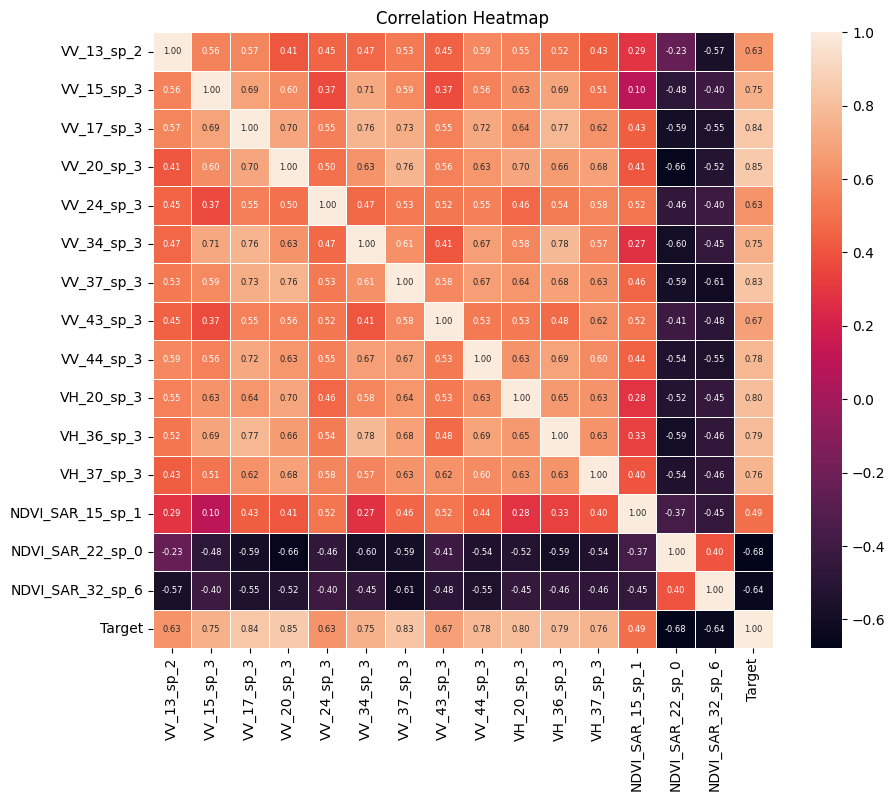

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_plot(dataframe):
    """
    Generates a correlation heatmap plot using Seaborn.

    Parameters:
    - dataframe: pandas DataFrame containing numeric columns.

    Returns:
    - None (displays the plot).
    """
    corr_matrix = dataframe.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5, annot_kws={"size": 6})
    plt.title('Correlation Heatmap')
    plt.show()

correlation_plot(df_)

In [295]:
from sklearn.manifold import TSNE
import plotly.express as px

def tsne_plot(dataframe, target_column):
    """
    Generates a t-SNE plot using Plotly with hover information to visualize high-dimensional data.

    Parameters:
    - dataframe: pandas DataFrame containing numeric columns.
    - target_column: Name of the target column in the DataFrame.

    Returns:
    - fig: Plotly Figure object containing the t-SNE plot with hover information.
    """
    X = dataframe.drop(columns=[target_column])
    y = dataframe[target_column]

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)
    hover_text = ['Index: {}'.format(index) for index in dataframe.index]
    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y, labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'}, color_continuous_scale='viridis', title='t-SNE Plot', hover_name=hover_text)
    fig.update_coloraxes(colorbar_title=target_column)

    return fig, X_tsne

fig, tsne = tsne_plot(df_, 'Target')

fig.show()


In [258]:
# df = df_.copy()
# train = df.iloc[[292,146],:]
# test = df.iloc[[370,234,112],:]
# df_ = df.drop([370,234,146,112,292])
# X = df_.drop(['Target'],axis=1)
# y = df_['Target']
# X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,shuffle=True, random_state=807410395)
# X_train = pd.concat([X_train,train.drop(['Target'],axis=1)]).reset_index(drop=True)
# y_train = pd.concat([y_train,train['Target']]).reset_index(drop=True)
# X_test = pd.concat([X_test,test.drop(['Target'],axis=1)]).reset_index(drop=True)
# y_test = pd.concat([y_test,test['Target']]).reset_index(drop=True)
# X = df.drop(['Target'],axis=1)
# y = df['Target']
# X_train.shape, y_train.sum()

In [259]:
clf = LogisticRegression(random_state=5000)
def rank_seeds(clf, topk=10):
    sd = {}
    for seed in tqdm(range(0,NUM_TRIALS)):
        scv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
        score = cross_val_score(clf, X_train, y_train, cv=scv.split(X_train, y_train), scoring='accuracy').mean()
        sd.update({seed:score})
    seeds = pd.DataFrame(list(sd.items()), columns=['Seed', 'Score']).sort_values('Score',ascending=True).index[0:topk].values.tolist()
    return seeds
seeds2 = rank_seeds(clf)

100%|██████████| 10000/10000 [00:58<00:00, 169.50it/s]


[1462, 9692, 5749, 1776, 6032, 7865, 4058, 7713, 7119, 1147]

In [332]:
seeds2=[1462, 9692, 5749, 1776, 6032, 7865, 4058, 7713, 7119, 1147]

In [334]:
#[621, 782, 209, 1922, 1897, 1620, 1992, 1627, 1599, 217]
#[1462, 9692, 5749, 1776, 6032, 7865, 4058, 7713, 7119, 1147]
def score_clf(clf):
    scores = []
    for seed in seeds2:
        scv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
        score = cross_val_score(clf, X_train, y_train, cv=scv.split(X_train, y_train), scoring='accuracy').mean()
        scores.append(score)
    return {'score':np.mean(scores),'sd':np.std(scores)}
score_clf(clf)

{'score': 0.9930303030303029, 'sd': 0.0047042953625029875}

In [261]:
model = clf.fit(X_train,y_train)
coefs = model.coef_.tolist()[0]
feat_imp = {c:i for c,i in zip(sel_feats,[abs(c) for c in coefs])}

In [262]:
def plot_fi(feat_imp):
    sorted_features = sorted(feat_imp.items(), key=lambda x: x[1], reverse=True)
    features = [item[0] for item in sorted_features]
    importance_scores = [item[1] for item in sorted_features]

    fig = go.Figure(data=[go.Bar(x=features, y=importance_scores)])
    fig.update_layout(title='Feature Importance', xaxis_title='Feature', yaxis_title='Importance Score')
    fig.show()

In [263]:
#NESTED CV STRATEGY TO SCORE THE VALIDATION SET
def nested_cv(
    pipe,
    X,
    y,
    grid,
    splits,
    iters=5,
    seed=42,
    metrics="accuracy",
):
    inner_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    outer_cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    clf = RandomizedSearchCV(estimator=pipe, n_iter=iters, param_distributions=grid, cv=inner_cv, 
                            scoring=metrics, n_jobs=-1, random_state=SEED)
    scores = cross_validate(clf, X=X, y=y, cv=outer_cv, scoring=metrics, return_estimator=True)
    model_params = [e.best_estimator_ for e in scores["estimator"]]
    return {
        "model_params": model_params,
        "accuracy": scores["test_score"],
    }

#FUNCTION TO RUN MULTIPLE NESTED CV TRIALS
def run_cvs(pipe, X, y, grid, splits=10, iters=5, metrics = 'accuracy'):
    cv_results = pd.DataFrame()
    row_res = {}

    for i in tqdm(range(NUM_TRIALS)): #ITERATE THROUGH NUMBER OF TRIALS
        row_res["seed"] = i
        cv_res = nested_cv(pipe, X, y, grid=grid, splits=splits, iters=iters, seed=i, metrics=metrics)
        row_res.update(cv_res)
        temp_res = pd.DataFrame(row_res, columns=list(row_res.keys()))
        cv_results = pd.concat([cv_results, temp_res], axis=0, ignore_index=True)
        row_res = {}
    return cv_results

#FUNCTION TO FIND THE WORST PERFORMING TRIAL OUT OF ALL THE TRIALS
def find_worst_seeds(res, topk=5):
    seeds = []
    for seed in res.groupby('seed')['accuracy'].mean().sort_values(ascending=True).index[0:topk].values:
        seeds.append(seed)
    return seeds

In [264]:
#BLOCK TO FIND THE WORST PERFORMING SEED ON THE DATA
lr_params = {
    "fit_intercept": [True, False],
    "C": np.linspace(0.01, 0.5, 40, dtype=np.float32),
    # "l1": np.linspace(0.1, 1.0, 40, dtype=np.float32),
    "solver": ["lbfgs"],
    "penalty": ["l2"],
}
clf = LogisticRegression(max_iter=200,random_state=420)
res_ridge = run_cvs(clf, X_train, y_train, lr_params, splits=5, iters=1, metrics='f1_weighted')
seeds = find_worst_seeds(res_ridge, topk=10)

100%|██████████| 10000/10000 [13:14<00:00, 12.59it/s]


In [265]:
seeds

[7011, 1591, 2211, 4813, 9112, 103, 9117, 8766, 2869, 90]

In [322]:
seeds = [7011, 1591, 2211]#[1633, 125, 1842, 1429, 340, 1344, 1088, 1956, 1114, 1682]

In [323]:
#MAKING VOTING CLASSIFIER USING A LIST OF MODELS
def make_vc(search_list, name_list):
    estimator_list = [(str(n), s) for n,s in zip(name_list, search_list)]
    return VotingClassifier(estimators=estimator_list, voting='soft')

def evaluate(clf):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(classification_report(y_test,predictions))

def predict_submission(clf, use_s2=False):
    testdfs1 = np.load('sar_data_test.npy')
    if use_s2:
        testdfs2 = np.load('sentinel2_data_test.npy')
        proc_testdf = proc_pipeline(testdfs1,testdfs2)
    else:
        proc_testdf = proc_pipeline(testdfs1,None)
    X_sub = proc_pipe.transform(proc_testdf)
    clf.fit(X,y)
    submission_predictions = clf.predict(X_sub)
    submission_probs = clf.predict_proba(X_sub)
    return submission_predictions, submission_probs

#THE FUNCTION TO CREATE VOTING CLASSIFIER BASED ON PERFORMANCE ON WORST PERFORMING SEED
def score_worst_seeds(clf, params, X, y, seeds, iters=100):
    model_ls = []
    valid_scores = []

    for seed in tqdm(seeds):
        cv_res = nested_cv(clf, X, y, grid=params, splits=5, iters=iters, seed=seed, metrics='f1_weighted')
        cv_models = cv_res['model_params']
        model = make_vc(cv_models, list([i for i in range(0,5)]))
        score = cv_res['accuracy'].mean()
        model_ls.append(model)
        valid_scores.append(score*100)

    print(f'The mean accuracy for the {len(seeds)} worst seeds is {np.mean(valid_scores)} and the std. dev. is {np.std(valid_scores)}')
    return make_vc(model_ls, seeds)

In [324]:
from sklearn.neural_network import MLPClassifier

mlp_params = {
    'hidden_layer_sizes': [(64,32), (32,16,8), (16,8), (16,8,4), (8,4,2)],
    'activation': ['relu', 'tanh', 'logistic'],
    # 'solver': ['adam'],
    'alpha': np.linspace(0.00001, 1.0, 10, dtype=np.float16),
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': np.linspace(1e-6, 1e-4, 10, dtype=np.float16),
    # 'batch_size': np.linspace(1, 16, 8, dtype=np.int16),
    # 'max_iter': np.linspace(1000, 10000, 20, dtype=np.int16),
    'beta_1': np.linspace(0.00001, 1.0, 10, dtype=np.float16),
    'beta_2': np.linspace(0.00001, 1.0, 10, dtype=np.float16),
    'epsilon': np.linspace(1e-8, 1e-5, 10, dtype=np.float16),
}
clf = MLPClassifier(batch_size=32, solver='adam', random_state=42, max_iter=5000, n_iter_no_change=10)
model_mlp = score_worst_seeds(clf, mlp_params, X_train, y_train, seeds, iters=10)

100%|██████████| 3/3 [03:06<00:00, 62.07s/it]

The mean accuracy for the 3 worst seeds is 99.19145505504154 and the std. dev. is 0.3782181173469017


In [325]:
rf_params = {
    "n_estimators": np.linspace(50, 100, 5, dtype=np.int16),
    "max_depth": np.linspace(2, 15, 10, dtype=np.int16),
    "min_samples_split": np.linspace(2, 20, 10, dtype=np.int16),
    "min_samples_leaf": np.linspace(2, 20, 10, dtype=np.int16),
    "criterion": ["gini", "entropy", "log_loss"],
    "ccp_alpha": np.linspace(0.0, 5.0, 20, dtype=np.float16),
}
clf = RandomForestClassifier(random_state=420)
model_rf = score_worst_seeds(clf, rf_params, X_train, y_train, seeds,iters=500)

100%|██████████| 3/3 [03:24<00:00, 68.27s/it]

The mean accuracy for the 3 worst seeds is 99.39380022962114 and the std. dev. is 0.2474800199367637


In [326]:
svm_params = {
    "kernel": ['rbf'],
    "C": np.linspace(0.001, 5.0, 50, dtype=np.float32),
    "gamma": np.linspace(0.01, 5.0, 50, dtype=np.float16),
}
clf = SVC(random_state=420, probability=True)
model_svm = score_worst_seeds(clf, svm_params, X_train, y_train, seeds, iters=1000)

100%|██████████| 3/3 [01:20<00:00, 26.85s/it]

The mean accuracy for the 3 worst seeds is 99.39370732550056 and the std. dev. is 0.24765067174364352


In [327]:
xgb_params = {
    "n_estimators": np.linspace(50, 100, 10, dtype=np.int16),
    "max_depth": np.linspace(2, 30, 15, dtype=np.int16),
    "max_leaves": np.linspace(2, 10, 6, dtype=np.int16),
    "learning_rate": np.linspace(1e-3, 1.0, 40, dtype=np.float16),
    "subsample": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "colsample_bytree": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "reg_alpha": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "reg_lambda": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "monotone_constraints": [None, (1, -1), (-1, 1)],
    "grow_policy": ["depthwise", "lossguide"],
}

clf = XGBClassifier(random_state=420)
model_xgb = score_worst_seeds(clf, xgb_params, X_train, y_train, seeds, iters=500)

100%|██████████| 3/3 [00:43<00:00, 14.55s/it]

The mean accuracy for the 3 worst seeds is 99.09028246775172 and the std. dev. is 0.247821214817184


In [328]:
lgbm_params = {
    "n_estimators": np.linspace(50, 100, 10, dtype=np.int16),
    "max_depth": np.linspace(2, 20, 20, dtype=np.int16),
    "num_leaves": np.linspace(2, 10, 6, dtype=np.int16),
    "learning_rate": np.linspace(1e-3, 1.0, 40, dtype=np.float16),
    "subsample": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "colsample_bytree": np.linspace(0.2, 1.0, 40, dtype=np.float16),
    "reg_alpha": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "reg_lambda": np.linspace(0.0, 1.0, 20, dtype=np.float16),
    "min_child_samples": np.linspace(2, 7, 5, dtype=np.int16),
}
clf = LGBMClassifier(random_state=420)
# res_lgbm = run_cvs(clf, X_train, y_train, lgbm_params, splits=5, iters=1, metrics='f1_weighted')
# display_results1(res_lgbm)
model_lgbm = score_worst_seeds(clf, lgbm_params, X_train, y_train, seeds, iters=1000)

100%|██████████| 3/3 [00:47<00:00, 15.93s/it]

The mean accuracy for the 3 worst seeds is 99.39380022962114 and the std. dev. is 0.2474800199367637


### Create ensemble of random forest and svm

In [329]:
search_list = [model_rf,model_svm]
name_list = ['rf','svm']
vclf = make_vc(search_list, name_list)

In [335]:
score_clf(vclf)

{'score': 0.9939393939393939, 'sd': 0.0}

### Measure performance on hold-out set

In [336]:
evaluate(vclf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00       135

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



### Prediction on submission data

In [337]:
submission = pd.read_csv('submission1.csv')
submission_predictions, _ = predict_submission(vclf, use_s2=False)
submission['target'] = submission_predictions.tolist()
submission.target = le.inverse_transform(submission.target)
# submission.to_csv('submission_model.csv', index=False)
len(submission[submission['target']=='Rice'])

105

In [18]:
np.linspace(start=3,stop=20,num=10)

array([ 3.        ,  4.88888889,  6.77777778,  8.66666667, 10.55555556,
       12.44444444, 14.33333333, 16.22222222, 18.11111111, 20.        ])

In [37]:
from itertools import combinations
combos = [list(combo) for combo in combinations(['rf', 'lgbm', 'xgb', 'mlp', 'svm'], 4)]
combos

[['rf', 'lgbm', 'xgb', 'mlp'],
 ['rf', 'lgbm', 'xgb', 'svm'],
 ['rf', 'lgbm', 'mlp', 'svm'],
 ['rf', 'xgb', 'mlp', 'svm'],
 ['lgbm', 'xgb', 'mlp', 'svm']]

In [18]:
import pandas as pd
import numpy as np
import random
import subprocess
import os

def sample_dict(original_dict, sample_size):
    """
    Function to sample elements from lists in a dictionary.

    :param original_dict: Dictionary with lists as values
    :param sample_size: Number of elements to sample from each list
    :return: New dictionary with sampled elements
    """
    new_dict = {}
    for key, value_list in original_dict.items():
        # Ensure sample size does not exceed the length of the list
        sample_size = min(sample_size, len(value_list))
        new_dict[key] = random.sample(value_list, sample_size)[0]
    return new_dict

experiment_space = {
    "pca": ["yes", "no"],
    "nfeats": np.linspace(start=10, stop=100, num=20, dtype=np.int16).tolist(),
    "knots": np.linspace(start=5, stop=20, num=10, dtype=np.int16).tolist(),
    "degree": np.linspace(start=2, stop=5, num=5, dtype=np.int16).tolist(),
    "ncomps": np.linspace(start=2, stop=10, num=5, dtype=np.int16).tolist(),
    "kernel": ["linear", "poly", "rbf", "sigmoid", "cosine"],
    "extrap": ['constant', 'linear', 'continue', 'periodic'],
    "nseeds": np.linspace(start=1, stop=5, num=5, dtype=np.int16).tolist(),
    # "mlp_iters": np.linspace(start=10, stop=100, num=20, dtype=np.int16).tolist(),
    "rf_iters": np.linspace(start=100, stop=1000, num=20, dtype=np.int16).tolist(),
    "xgb_iters": np.linspace(start=100, stop=1000, num=20, dtype=np.int16).tolist(),
    "lgbm_iters": np.linspace(start=100, stop=2000, num=20, dtype=np.int16).tolist(),
    "svm_iters": np.linspace(start=100, stop=2000, num=20, dtype=np.int16).tolist(),
    "ada_iters": np.linspace(start=100, stop=1000, num=20, dtype=np.int16).tolist(),
    "bag_iters": np.linspace(start=100, stop=1000, num=20, dtype=np.int16).tolist(),
    "knn_iters": np.linspace(start=100, stop=500, num=20, dtype=np.int16).tolist(),
    "gbm_iters": np.linspace(start=100, stop=2000, num=20, dtype=np.int16).tolist(),
    "xt_iters": np.linspace(start=100, stop=2000, num=20, dtype=np.int16).tolist(),
    "Ncombs": np.linspace(start=2, stop=5, num=3, dtype=np.int16).tolist()
}


In [19]:
args_dict = sample_dict(experiment_space, 1)
args_dict

{'pca': 'yes',
 'nfeats': 66,
 'knots': 15,
 'degree': 2,
 'ncomps': 4,
 'kernel': 'linear',
 'extrap': 'linear',
 'nseeds': 3,
 'rf_iters': 336,
 'xgb_iters': 289,
 'lgbm_iters': 2000,
 'svm_iters': 200,
 'ada_iters': 952,
 'bag_iters': 857,
 'knn_iters': 457,
 'gbm_iters': 900,
 'xt_iters': 400,
 'Ncombs': 3}

In [9]:
args_dict.values()

dict_values(['no', 66, 13, 3, 2, 'sigmoid', 'periodic', 4, 194, 621, 200, 1100, 431, 905, 457, 900, 800, 2])

In [35]:
def hashable_dict(d):
    """
    Converts a dictionary into a hashable tuple.
    
    Parameters:
    d (dict): The input dictionary.

    Returns:
    tuple: A hashable representation of the dictionary.
    """
    return tuple(sorted(d.items()))

def cache(func):
    """
    A decorator that caches the arguments of the function call.
    
    Parameters:
    func (function): The function to be cached.

    Returns:
    function: The wrapped function with caching.
    """
    cache_set = set()

    def cached_func(*args):
        # Convert any dictionary arguments to a hashable type
        hashable_args = tuple(hashable_dict(arg) if isinstance(arg, dict) else arg for arg in args)
        if hashable_args in cache_set:
            print(f"Skipping {args} as it is already cached.")
            return
        cache_set.add(hashable_args)
        return func(*args)

    return cached_func

def run_experiments(args_dict, N):
    """
    Sample function to run experiments.
    
    Parameters:
    args_dict (dict): Dictionary of arguments.
    N (int): Number of experiments.
    
    This function does not return anything.
    """
    print(f"Running experiments with {args_dict} for {N} iterations.")


cached_run_experiments = cache(run_experiments)
cached_run_experiments(args_dict, 10)  # Will run and cache
cached_run_experiments(args_dict, 10)  # Will skip as it's already cached


Running experiments with {'param1': 'value1', 'param2': 'value2'} for 10 iterations.
Skipping ({'param1': 'value1', 'param2': 'value2'}, 10) as it is already cached.


In [36]:
def run_experiments(experiment_space, N=100):
    import time
    while(N>0):
        args_dict = sample_dict(experiment_space, 1)
        cmd = "python main.py"
        for k,v in args_dict.items():
            cmd +=  " "+ str(v)
        # subprocess.run(cmd, shell=True)
        N -= 1
        # time.sleep(30)
        print(cmd)

import os
import pickle

def hashable_dict(d):
    return tuple(sorted(d.items()))

def load_cache(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return set()

def save_cache(cache, filename):
    with open(filename, 'wb') as f:
        pickle.dump(cache, f)

def cache(func, cache_file='cache.pkl'):
    cache_set = load_cache(cache_file)

    def cached_func(*args):
        hashable_args = tuple(hashable_dict(arg) if isinstance(arg, dict) else arg for arg in args)
        if hashable_args in cache_set:
            print(f"Skipping {args} as it is already cached.")
            return
        cache_set.add(hashable_args)
        save_cache(cache_set, cache_file)
        return func(*args)

    return cached_func

if __name__ == "__main__":
    experiment_space = {
        # Define your experiment space here
    }

    def sample_dict(space, num_samples):
        return {"param1": "value1", "param2": "value2"}

    args_dict = sample_dict(experiment_space, 1)
    cached_run_experiments = cache(run_experiments, 'experiment_cache.pkl')
    cached_run_experiments(args_dict, 10)  # Will run and cache
    cached_run_experiments(args_dict, 10)  # Will skip as it's already cached


Skipping ({'param1': 'value1', 'param2': 'value2'}, 10) as it is already cached.
Skipping ({'param1': 'value1', 'param2': 'value2'}, 10) as it is already cached.


In [54]:
import scipy.stats as stats

def t_dist_lower_bound(mean, std_dev, sample_size, confidence_level=0.99):
    """
    Calculate the lower bound of a t-distributed random variable.

    Parameters:
    mean (float): The mean of the t-distributed random variable.
    std_dev (float): The standard deviation of the t-distributed random variable.
    sample_size (int): The sample size.
    confidence_level (float): The confidence level (between 0 and 1).

    Returns:
    float: The lower bound of the t-distributed random variable.
    """
    if sample_size==1:
        return mean
    df = sample_size - 1  # Degrees of freedom
    alpha = 1 - confidence_level
    t_critical = stats.t.ppf(alpha / 2, df)
    margin_of_error = t_critical * (std_dev / (sample_size ** 0.5))
    lower_bound = mean + margin_of_error
    return lower_bound

# Example usage
mean = 99.09
std_dev = 0.0
ss = 1  # degrees of freedom
confidence_level = 0.99

lower_bound = t_dist_lower_bound(mean, std_dev, ss, confidence_level)
print(f"Lower bound: {lower_bound}")


Lower bound: 99.09


In [57]:
example_dict = {
        'a_rc': 10,
        'b_rc': 15,
        'c_rc': 5,
        'd_rc': 20,
        'e_rc': 1
    }

[s.split('_')[0] for s in sorted(example_dict, key=example_dict.get, reverse=True)[:4]]

['d', 'b', 'a', 'c']

In [1]:
def get_keys_above_threshold(d, threshold):
    # Sort the dictionary by values in descending order
    sorted_items = sorted(d.items(), key=lambda item: item[1], reverse=True)
    
    # Filter keys with values above the threshold
    keys_above_threshold = [key for key, value in sorted_items if value > threshold]
    
    return keys_above_threshold

# Example usage
example_dict = {
    'a': 10,
    'b': 15,
    'c': 5,
    'd': 20,
    'e': 1
}

threshold = 10
keys_above_threshold = get_keys_above_threshold(example_dict, threshold)
print(keys_above_threshold)  # Output: ['d', 'b']


['d', 'b']
